# Explainable emotion recognition

**Outline of the project :**
- Implement simple Facial Expression Recognition (FER) on FER2013 and AffectNet datasets
- Implement GradCAM
- Extend this to video (see ressources : In search of a robust facial expressions recognition model: A large-scale visual cross-corpus study) for datasets of dynamic emotion recognition

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

## Load the dataset

In [16]:
train_dir = "data/fer2013/train" 
test_dir = "data/fer2013/test" 
val_dir = "data/fer2013/val" 

visu_transform = transforms.ToTensor()

visuset = datasets.ImageFolder(root=test_dir, transform=visu_transform)

class_to_idx = {"Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6}
idx_to_class = {v: k for k, v in class_to_idx.items()}

n_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

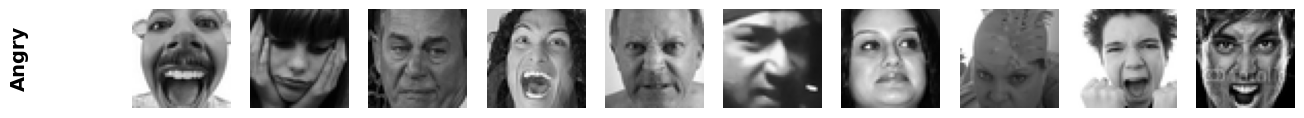

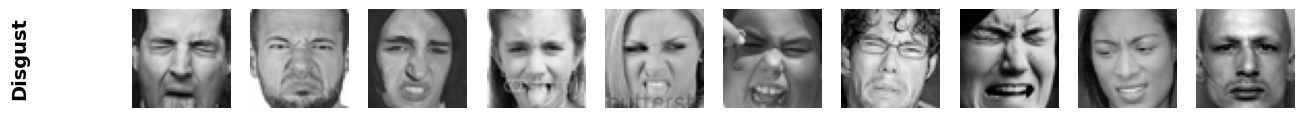

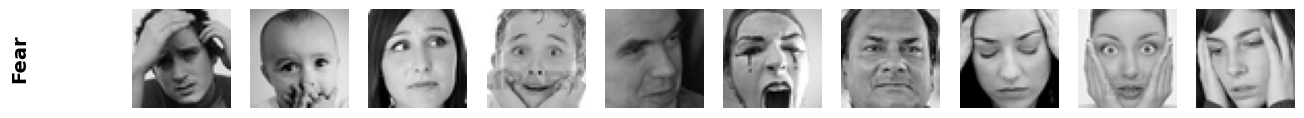

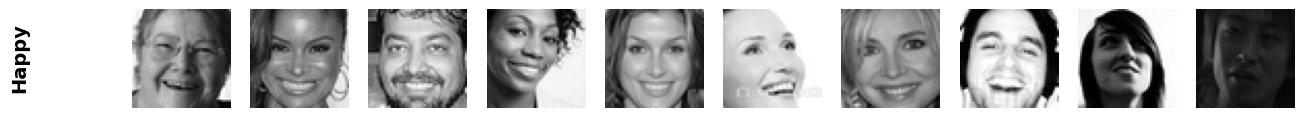

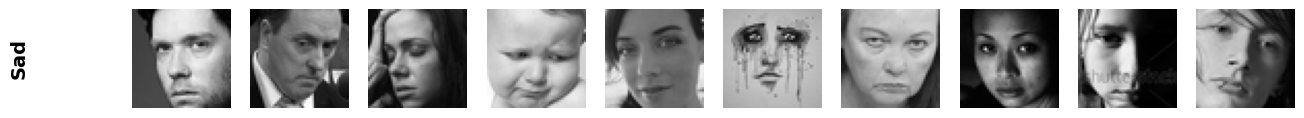

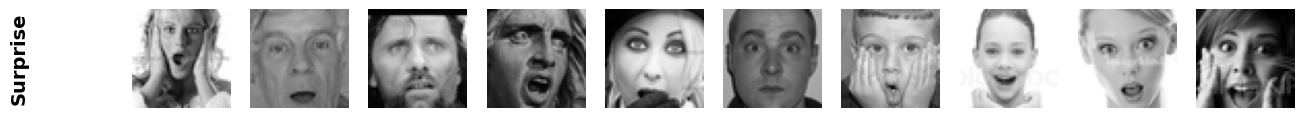

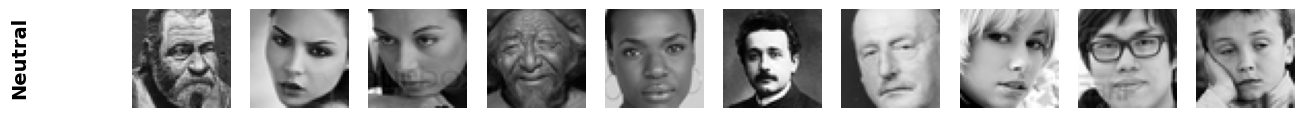

In [11]:
N = 10

visuloader = DataLoader(visuset, batch_size=None, shuffle=True)

# Find N examples per class
examples = {i: [] for i in range(n_classes)}
for img, label in visuloader:
    if len(examples[label]) < N:
        examples[label].append(img)
    if all(len(examples[i]) == N for i in range(n_classes)):
        break

# Plot examples
for i in range(n_classes):
    fig = plt.figure(figsize=(15, 2))
    for j in range(N):
        plt.subplot(1, N, j+1)
        plt.imshow(examples[i][j].permute(1, 2, 0))
        plt.axis("off")
    fig.text(0.05, 0.5, idx_to_class[i], va="center", ha="center", fontsize=14, fontweight="bold", rotation=90)

    plt.show()


## Finetune ResNet model

In [22]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
preprocess = weights.transforms()

model.fc = nn.Linear(512, n_classes)
print(model)

model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Training data

train_transform = transforms.Compose([
    preprocess
])

val_transform = train_transform
trainset = datasets.ImageFolder(root=train_dir, transform=train_transform)
valset = datasets.ImageFolder(root=val_dir, transform=val_transform)

In [26]:
# Training loop

def train(n_epochs, model, trainloader, valloader, optimizer, criterion):

    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(n_epochs):

        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))

        model.eval()
        val_loss, accuracy = 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                val_loss += loss.item()
                accuracy += (outputs.argmax(dim=1) == labels.to(device)).float().mean().item()
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(accuracy / len(valloader))

        print(f">> Training loss: {train_losses[-1]:.4f} - Validation loss: {val_losses[-1]:.4f} - Validation accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_accuracy(val_accuracies):
    plt.plot(val_accuracies, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Epoch 10/10 - Validation: 100%|██████████| 57/57 [00:06<00:00,  8.24it/s]


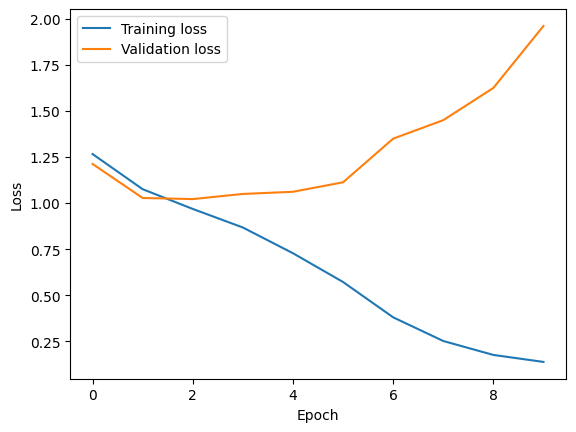

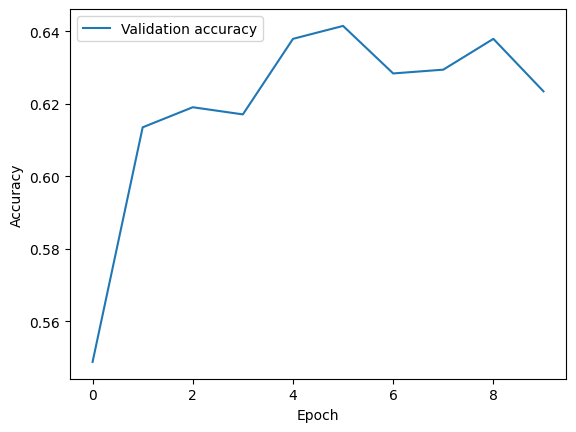

In [25]:
# Training

n_epochs = 10
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

train_losses, val_losses, val_accuracies = train(n_epochs, model, trainloader, valloader, optimizer, criterion)
plot_loss(train_losses, val_losses)
plot_accuracy(val_accuracies)